In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os
import numpy as np
from utils_eval import extract_metrics
import torch
from tensor_builder import getDataSet
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score



In [2]:
def get_cf(person, model, norm, window_size, stride, device, batch_size=-1):
    person = [person] if isinstance(person, str) else person

    dataset = getDataSet(randomState=None, window_size=window_size, stride=stride, 
                        flatten=False, specific_ppl=person)
    
    if batch_size == -1:
        batch_size = len(dataset)
    
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).squeeze()
            outputs = model(X_batch)
            predictions = (torch.sigmoid(outputs) > 0.5).long().flatten()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds, normalize=norm)
    
    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds)
    
    return conf_matrix, f1

In [3]:
# def plot_performance_metrics(ppls, model, norm, window_size, stride, device):
#     # Lists to store results
#     cf_scores = []
#     f1_scores = []
    
#     # Loop through each person and get scores
#     for person in ppls:
#         cf, f1 = get_cf(person=person, model=model, norm=norm, window_size=window_size, stride=stride, device=device)  
#         cf_scores.append(cf)
#         f1_scores.append(f1)
    
#     plt.figure(figsize=(12, 6))
    
#     width = 0.35
#     x = np.arange(len(ppls))
    
#     plt.bar(x - width/2, cf_scores, width, label='CF Score', color='skyblue')
#     plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightgreen')
    
#     plt.xlabel('Person ID')
#     plt.ylabel('Score')
#     plt.title('CF and F1 Scores by Person')
#     plt.xticks(x, ppls, rotation=45)
#     plt.legend()
    
#     plt.grid(True, alpha=0.3)
    
#     plt.tight_layout()
    
#     return plt.gcf()
def plot_performance_metrics(ppls, model, norm, window_size, stride, device):
    # Lists to store results
    cf_matrices = []
    f1_scores = []
    
    # Loop through each person and get scores
    for person in ppls:
        cf_matrix, f1 = get_cf(person, model, norm, window_size, stride, device)
        cf_matrices.append(cf_matrix)
        f1_scores.append(f1)
    
    # Create figure and axis
    plt.figure(figsize=(12, 6))
    
    # Create grid for subplots
    rows = (len(ppls) + 3) // 4  # Ceiling division by 4
    cols = min(4, len(ppls))
    
    for idx, (person, cf_matrix) in enumerate(zip(ppls, cf_matrices)):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(cf_matrix, cmap='viridis')
        plt.title(f'Person {person}')
        plt.colorbar()
        
        # Add text annotations to the matrix
        for i in range(2):
            for j in range(2):
                plt.text(j, i, f'{cf_matrix[i, j]:.2f}', 
                        ha='center', va='center')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Return the figure
    return plt.gcf()

In [4]:
def main(eval_dir_path, ppls, norm='true', f1=True):
    head_tail = os.path.split(eval_dir_path)
    if f1:
        model_path = os.path.join(eval_dir_path, f'{head_tail[1]}_bestLoss.pth')
    else:
        model_path = os.path.join(eval_dir_path, f'{head_tail[1]}_bestF1.pth')

    txt_path = os.path.join(eval_dir_path, f'desc.txt')
    with open(txt_path, 'r') as f:
        content = f.read()
    dic = eval(content)
    window_size, stride = dic['window_size'], dic['stride'] 

    model = torch.load(model_path)
    model.eval()
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    # Create and show the plot
    fig = plot_performance_metrics(ppls=ppls, model=model, norm=norm, window_size=window_size, stride=stride, device=device)
    plt.show()

Using device: cuda:1


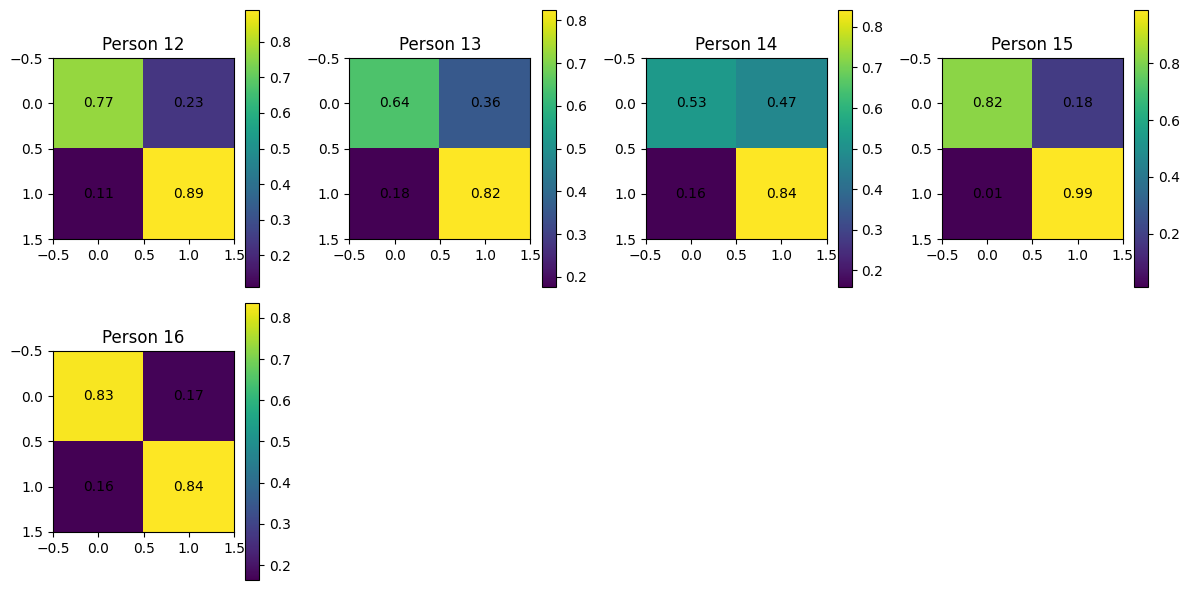

In [5]:
eval_dir_path = '/home/kuba/Projects/MedicationTakingData/resmodel/res_search_00/res_search_00_7'
cf_norm_on = 'true' # 'pred  
if_f1 = True

ppls = ["12", "13", "14", "15", "16"]


main(eval_dir_path, ppls, cf_norm_on, if_f1)

